In [1]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
% cp -r /content/drive/My\ Drive/Colab\ Notebooks/age_classification/agedata_cut.zip /content
! unzip /content/agedata_cut.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/agedata_cut/26_1_2_20170116184827669.jpg  
  inflating: /content/agedata_cut/68_1_0_20170110175311202.jpg  
  inflating: /content/agedata_cut/2_0_0_20161219161216590.jpg  
  inflating: /content/agedata_cut/24_1_3_20170104231923674.jpg  
  inflating: /content/agedata_cut/1_1_2_20161219195107011.jpg  
  inflating: /content/agedata_cut/29_0_1_20170116194210361.jpg  
  inflating: /content/agedata_cut/28_0_2_20170116162829960.jpg  
  inflating: /content/agedata_cut/69_0_0_20170109011208585.jpg  
  inflating: /content/agedata_cut/18_0_3_20170104230329273.jpg  
  inflating: /content/agedata_cut/81_0_0_20170117091321806.jpg  
  inflating: /content/agedata_cut/1_1_0_20170109191023360.jpg  
  inflating: /content/agedata_cut/25_1_3_20170104231305129.jpg  
  inflating: /content/agedata_cut/32_1_0_20170117094855375.jpg  
  inflating: /content/agedata_cut/26_1_0_20170116184604799.jpg  
  inflating: /content/agedata_cut/26_0_1_2

In [4]:
!ls

agedata_cut  agedata_cut.zip  drive  sample_data


In [0]:
batch_size = 64
epoch_num = 60
IMG_SIZE = 224
N_CHANNELS = 3

output_1, output_2, output_3 = 'dense_age', 'dense_gender', 'dense_eth'

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
print(tf.__version__)

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import layers,losses,metrics,optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import pathlib
import os
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


from sklearn.model_selection import train_test_split



2.2.0-rc2


In [0]:
def get_labels(r):
    r['age'], r['gender'],r['eth'] = tuple(r['filename'].split('_'))[:3]
    return r

ds_df = pd.DataFrame({'filename':os.listdir('agedata_cut')})
ds_df = ds_df.apply(lambda r: get_labels(r),axis=1)
ds_df['filename'] = ds_df['filename'].apply(lambda x: os.path.join('/content/agedata_cut',x))



In [0]:
ds_df['gender'] = pd.to_numeric(ds_df['gender'], errors='coerce')
ds_df['eth'] = pd.to_numeric(ds_df['eth'], errors='coerce')
ds_df['age'] = pd.to_numeric(ds_df['age'], errors='coerce')
ds_df = ds_df.dropna()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff18c1676d8>,
      dtype=object)

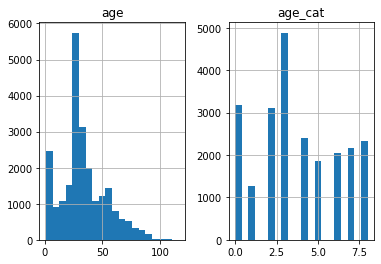

In [0]:
## Categorize age
age_list = [0, 10, 18, 25, 30, 35, 40, 50, 60, 120]
ds_df['age_cat'] = len(age_list)
for i, age in enumerate(age_list):
    ds_df['age_cat'].loc[ds_df['age']>age] = i

ds_df[['age', 'age_cat']].hist(bins=20)

In [0]:
df_train, df_valid = train_test_split(ds_df, test_size=0.2, random_state=42)

In [0]:
df_train

,filename,age,gender,eth,age_cat
1771,/content/agedata_cut/72_0_2_20170111200724572.jpg,72,0,2,8
7609,/content/agedata_cut/30_0_0_20170117131018041.jpg,30,0,0,3
13883,/content/agedata_cut/9_0_0_20170110225101384.jpg,9,0,0,0
3323,/content/agedata_cut/6_1_0_20170109201859697.jpg,6,1,0,0
18258,/content/agedata_cut/34_0_3_20170119165846359.jpg,34,0,3,4
...,...,...,...,...,...
11964,/content/agedata_cut/34_0_1_20170116194219198.jpg,34,0,1,4
21575,/content/agedata_cut/40_1_1_20170117000145761.jpg,40,1,1,5
5390,/content/agedata_cut/47_0_0_20170117204124336.jpg,47,0,0,6
860,/content/agedata_cut/17_1_0_20170109213621558.jpg,17,1,0,1


In [0]:
def _parse_function(filename,labels):
    image_string = tf.io.read_file(filename) 
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_resized /= 255
    return image_resized, labels

In [0]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

    # Load the list of files
    filenames = tf.constant(dataframe['filename'].tolist())

    # Load the labels
    Y_age = pd.get_dummies(dataframe['age_cat']).values.astype('int32')
    Y_gender = pd.get_dummies(dataframe['gender']).values.astype('int32')
    Y_eth = pd.get_dummies(dataframe['eth']).values.astype('int32')
    labels = {output_1: Y_age, output_2: Y_gender, output_3: Y_eth}

    # Build the dataset with image processing on top of it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    # Add shuffling and repeatition if training
    if is_eval:
      dataset = dataset.batch(batch_size)
    else:
      dataset = dataset.repeat().shuffle(1000).batch(batch_size)

    return dataset

In [0]:
ds_train = input_fn(df_train, is_eval=False)
ds_valid = input_fn(df_valid, is_eval=True)



In [0]:
ds_valid

<BatchDataset shapes: ((None, 224, 224, 3), {dense_age: (None, 9), dense_gender: (None, 2), dense_eth: (None, 5)}), types: (tf.float32, {dense_age: tf.int32, dense_gender: tf.int32, dense_eth: tf.int32})>

In [0]:
for img, labels in ds_train.take(1):
    break

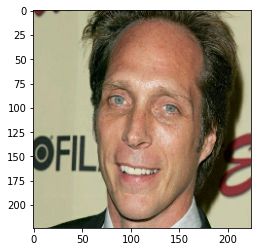

In [0]:
plt.figure()
plt.imshow(img[12])


# Model

In [0]:
# class create_model(Model):
#     def __init__(self):
#         super(create_model, self).__init__()
#         self.MobileNet = tf.keras.applications.MobileNet()
#         self.conv1 = Conv2D(32, 3, activation='relu')
#         self.flatten = Flatten()
#         self.d1 = Dense(128, activation='relu')
#         self.d2 = Dense(10, activation='softmax')
#         self.d_age = Dense(9, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_age')
#         self.d_gender = Dense(2, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_gender')
#         self.d_eth = Dense(5, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_eth')
        
#         self.Dropout = tf.keras.layers.Dropout(0.1)

#     def call(self, x):
#         x = self.conv1(x)
#         # x = self.MobileNet(x)
#         x = self.flatten(x)
#         x = self.Dropout(x)
#         x = self.d1(x)
#         # x = self.Dropout(x)

#         head_age = Dense(9, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name='dense_age')(x)
#         head_gender = self.d_gender(x)
#         head_eth = self.d_eth(x)
#         return [head_age, head_gender, head_eth]
     

In [0]:
# denseBlock4
import keras
import tensorflow as tf
IMG_SIZE=224
N_CHANNELS = 3
input_shape = [IMG_SIZE,IMG_SIZE,N_CHANNELS]
inputs = Input(shape=input_shape)



out1 = tf.nn.separable_conv2d(inputs,  [3,3,128,1],[1,1,128,128], [1,2,2,1],'SAME')
# out1 = tf.keras.layers.DepthwiseConv2D((3, 3),
#                                padding='same' ,
#                                depth_multiplier=1,
#                             #    strides=strides,
#                                use_bias=False,)(inputs)
# out2 = tf.nn.separable_conv2d(out1, [3,3,128,1],[1,1,128,128],[1,1,1,1])
# in3 = tf.relu(keras.layers.Add()([out1, out2]))



ValueError: ignored

In [0]:
# denseBlock4
input_shape = [IMG_SIZE,IMG_SIZE,N_CHANNELS]
inputs = Input(shape=input_shape)
out1 = tf.nn.separable_conv2d(inputs, [3,3,128,1], [1,1,128,128], [1,2,2,1],'SAME')
out2 = tf.nn.separable_conv2d(out1, [3,3,128,1],[1,1,128,128],[1,1,1,1])
in3 =
x2 = keras.layers.Dense(8, activation='relu')(input2)
# equivalent to `added = keras.layers.add([x1, x2])`
added = keras.layers.Add()([x1, x2])
out = keras.layers.Dense(4)(added)


In [0]:
def create_model():
    input_shape = [IMG_SIZE,IMG_SIZE,N_CHANNELS]
    inputs = Input(shape=input_shape)


    # x = Conv2D(32, 3, activation='relu')(inputs)
    x = tf.keras.applications.MobileNetV2()(inputs)
    # x = Flatten()(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    # x = self.Dropout(x)

    head_age = Dense(9, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name=output_1)(x)
    head_gender = Dense(2, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name=output_2)(x)
    head_eth = Dense(5, activation = 'softmax',kernel_initializer='he_normal',dtype='float32', name=output_3)(x)

    model = Model(inputs=inputs, outputs=[head_age, head_gender, head_eth])
    return model

In [0]:
def lr_schedule(epoch):
    
    lr = 1e-3
    
    lr = 0.5*(1+np.cos((epoch/epoch_num)*np.pi))*lr
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

optimizer = Adam(lr=lr_schedule(0),amsgrad=True)


Learning rate:  0.001


In [0]:

# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
# print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

# print("REPLICAS: ", strategy.num_replicas_in_sync)

# with strategy.scope():
#     model = create_model()
#     model.compile(optimizer='adam',
#                   loss=tf.keras.losses.categorical_crossentropy,
#                   metrics=['accuracy'])

In [0]:
model = create_model()
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.categorical_crossentropy,
#               metrics=['accuracy'])
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

14540800/14536120 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 1000)         3538984     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1000)         0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          256256      dropout[0][0]                    
_____________________________

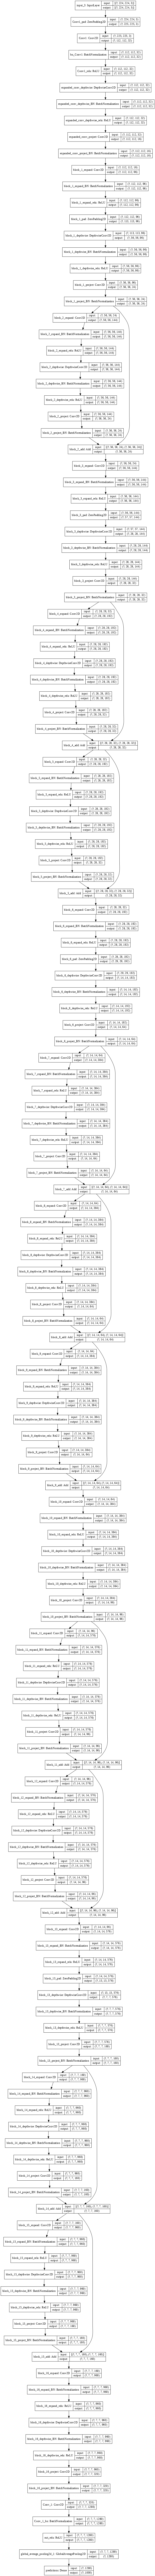

In [0]:
tf.keras.utils.plot_model(tf.keras.applications.MobileNetV2(), show_shapes=True, dpi=64)

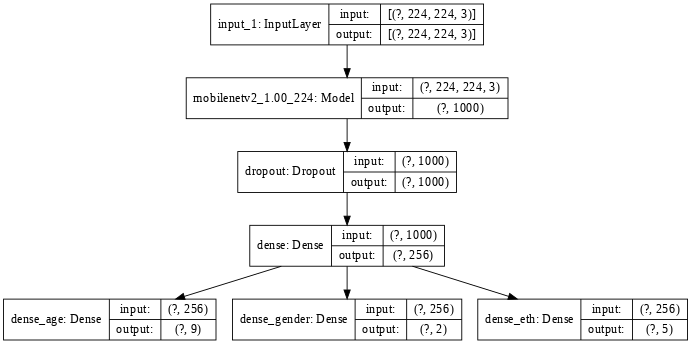

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

# Data augmentation

In [0]:
class GridMask():
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        # super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

gm = GridMask(mode=0, num_grid=3)
gm.init_masks(IMG_SIZE,IMG_SIZE)
init_masks = tf.cast(gm.masks[0], dtype='float32')

# @tf.function
def add_mask(s):
    # random_angle = tf.random.uniform([1])[0]*np.pi
    # rotated_masks = tfa.image.rotate(init_masks, random_angle)
    # mask_single = tf.image.random_crop(rotated_masks,[IMG_SIZE,IMG_SIZE])

    mask_single = tf.image.random_crop(init_masks,[IMG_SIZE,IMG_SIZE])
    mask_batch = tf.reshape(mask_single, [1,IMG_SIZE,IMG_SIZE,1])

    s *= mask_batch
    return s


In [0]:
# add_mask(img)
# img.shape

In [0]:
# test = img[0,:,:,1]
# mask_single = tf.reshape(test, [1,IMG_SIZE,IMG_SIZE,1])
# mask_batch = tf.repeat(mask_single, repeats=batch_size, axis=0)
# mask_batch3d = tf.repeat(mask_batch, repeats=3, axis=3)

# mask_batch3d*mask_batch3d

In [0]:
def resize_image(s, L):
    s = tf.image.resize(s,
                        tf.constant([L,L]),
                        # method=tf.image.ResizeMethod.BICUBIC,
                        # antialias=True
                            )
    return s

def random_crop(s):
    s = resize_image(s, L=int(IMG_SIZE*1.2))
    s = tf.image.random_crop(s, [batch_size, IMG_SIZE, IMG_SIZE, N_CHANNELS])
    return s

def random_flip(s):
    if tf.random.uniform([1])[0]<0.5:
        s = tf.image.flip_left_right(s)
    return s

def color_jitter(s):
    s = tf.image.adjust_saturation(s, tf.random.uniform([1], 0.5,1.5)[0]) # saturation from 0.5 to 1.5
    s = tf.image.adjust_brightness(s, tf.random.uniform([1], -0.5, 0.5)[0]) # brightness from -0.4(dark) to 0.4(light)
    s = tf.clip_by_value(s, 0, 1)
    return s


## mixup v3  
def mix_up(s,b):
    alpha=1
    lamA = np.random.beta(alpha, alpha, [batch_size,1])
    lamB = 1-lamA
    ## Reorder according to permutation
    perm = tf.random.shuffle(tf.range(batch_size))
    sm = tf.gather(s, perm, axis=0)
    bm1 = tf.gather(b['dense_1'], perm, axis=0)
    bm2 = tf.gather(b['dense_2'], perm, axis=0)
    bm3 = tf.gather(b['dense_3'], perm, axis=0)

    b_out = {}
    s = lamA.reshape([-1,1,1,1])*s+lamB.reshape([-1,1,1,1])*sm
    b_out[output_1] = lamA*tf.cast(b[output_1], dtype='float32')+lamB*tf.cast(bm1, dtype='float32')
    b_out[output_2] = lamA*tf.cast(b[output_2], dtype='float32')+lamB*tf.cast(bm2, dtype='float32')
    b_out[output_3] = lamA*tf.cast(b[output_3], dtype='float32')+lamB*tf.cast(bm3, dtype='float32')
    
    return s, b_out


In [0]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [0]:
i = 21
ori = img[i]
aug = add_mask(img)[i]
visualize(ori,aug)

In [0]:
@tf.function
def mapped_function(s,b):
    if tf.random.uniform([1])[0]<0.75:
        s = random_crop(s)  
        s = random_flip(s)
        s = color_jitter(s)
        s = add_mask(s)
    else :
        s = random_crop(s)  
        s = random_flip(s)
        s = color_jitter(s)
    return s,b


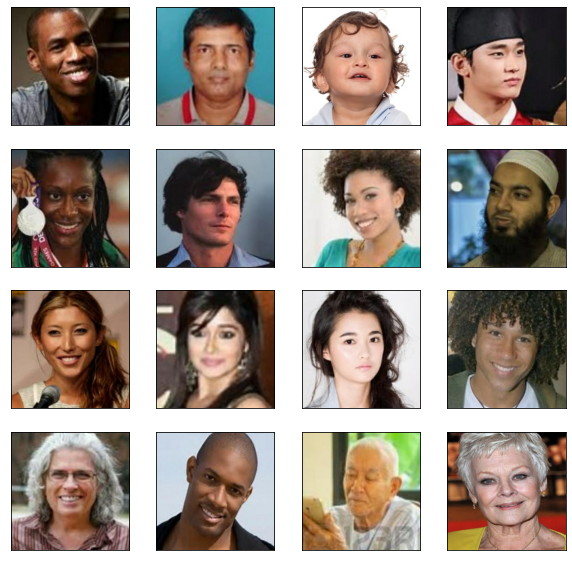

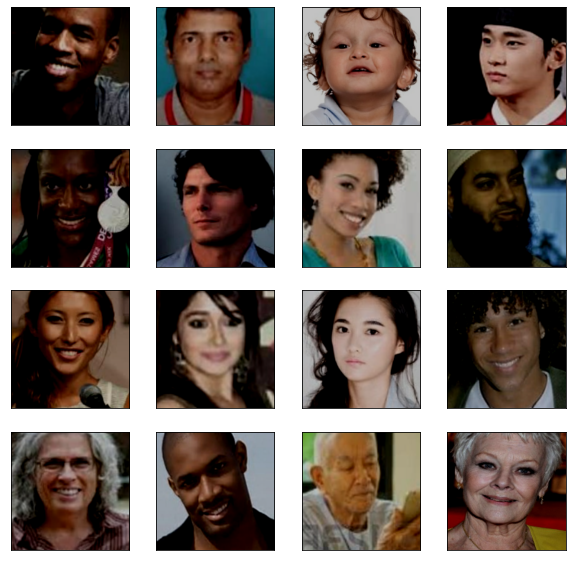

In [0]:
X_examples = list(ds_train.take(2).as_numpy_iterator())[0][0]
y_examples = list(ds_train.take(2).as_numpy_iterator())[0][1]
# image_examples = reshape_image(X_examples)
# image_examples = resize_image(image_examples)
image_examples = X_examples
plt.figure(figsize=(10,10))
for i in range(16):
    image_plot = np.array(image_examples[i])
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_plot, cmap=plt.cm.binary)
plt.show()

image_examples, target_examples = mapped_function(X_examples,y_examples)
plt.figure(figsize=(10,10))
for i in range(16):
    image_plot = np.array(image_examples[i])
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_plot, cmap=plt.cm.binary)
plt.show()

# Training

In [0]:
## Callback
learning_rate_reduction_output_1 = ReduceLROnPlateau(monitor=f'{output_1}_accuracy', 
                                                 patience=3, verbose=1,
                                                 factor=0.5, min_lr=1e-5)

## checkpoint
pass

## tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# %load_ext tensorboard
# %tensorboard --logdir logs/scalars


In [0]:
history = model.fit(ds_train.map(mapped_function,num_parallel_calls=tf.data.experimental.AUTOTUNE), 
                    validation_data=ds_valid,
                    epochs=epoch_num, 
                    steps_per_epoch = df_train.shape[0] // batch_size,
                    validation_steps = df_valid.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction_output_1, lr_scheduler]
                    )

Learning rate:  0.001
Epoch 1/60
290/290 [==============================] - 103s 354ms/step - loss: 3.9848 - dense_age_loss: 2.0029 - dense_gender_loss: 0.5825 - dense_eth_loss: 1.3995 - dense_age_accuracy: 0.2503 - dense_gender_accuracy: 0.7064 - dense_eth_accuracy: 0.4351 - val_loss: 4.7613 - val_dense_age_loss: 2.2591 - val_dense_gender_loss: 0.8835 - val_dense_eth_loss: 1.6187 - val_dense_age_accuracy: 0.1395 - val_dense_gender_accuracy: 0.4824 - val_dense_eth_accuracy: 0.4236 - lr: 1.0000e-03
Learning rate:  0.0009993147673772868
Epoch 2/60
290/290 [==============================] - 102s 353ms/step - loss: 3.4502 - dense_age_loss: 1.7831 - dense_gender_loss: 0.4448 - dense_eth_loss: 1.2222 - dense_age_accuracy: 0.3446 - dense_gender_accuracy: 0.7903 - dense_eth_accuracy: 0.5257 - val_loss: 4.9590 - val_dense_age_loss: 2.4319 - val_dense_gender_loss: 0.8963 - val_dense_eth_loss: 1.6309 - val_dense_age_accuracy: 0.1458 - val_dense_gender_accuracy: 0.5193 - val_dense_eth_accuracy: 0.

In [0]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10)) 
    plt.plot(np.arange(0, epoch), his.history['loss'], 'k', label='train_loss')
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_loss'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_loss'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_loss'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_loss'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_loss'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_loss'], 'b--', label=f'val_{output_3}')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure(figsize=(10,10))
    plt.yticks(np.arange(0.1,1.05,0.01))
    plt.xticks(np.arange(0,61,1))
    plt.plot(np.arange(0, epoch), his.history[f'{output_1}_accuracy'], 'r', label=f'train_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_2}_accuracy'], 'g', label=f'train_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'{output_3}_accuracy'], 'b', label=f'train_{output_3}')
    
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_1}_accuracy'], 'r--', label=f'val_{output_1}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_2}_accuracy'], 'g--', label=f'val_{output_2}')
    plt.plot(np.arange(0, epoch), his.history[f'val_{output_3}_accuracy'], 'b--', label=f'val_{output_3}')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

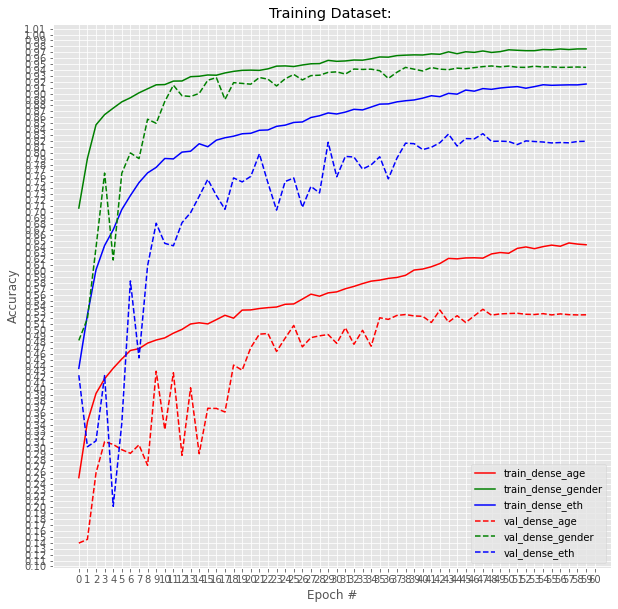

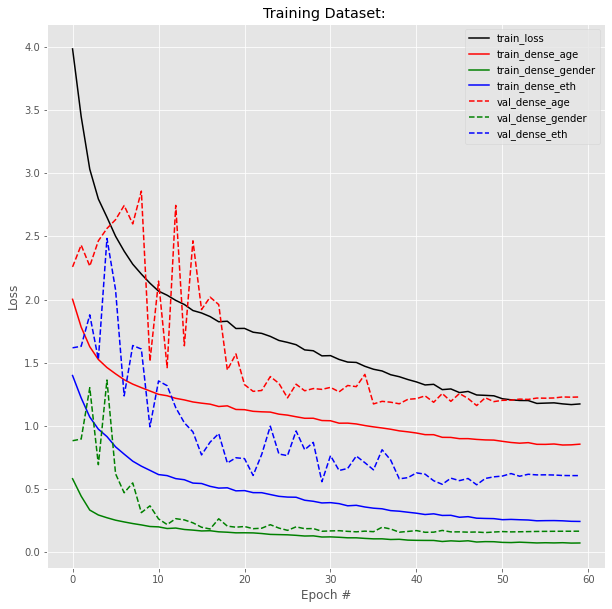

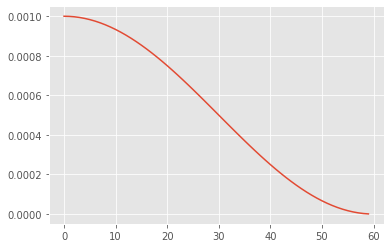

In [0]:
plot_acc(history, epoch_num, 'Training Dataset: ')
plot_loss(history, epoch_num, 'Training Dataset: ')

plt.figure()
plt.plot(history.epoch, history.history['lr'])

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir logs/scalars

In [0]:
# PATH = '/content/drive/My Drive/Colab Notebooks/age_classification/save_weights'
# # model.save_weights(PATH+"/resnext20_80epochs.h5")
# model.save_weights(PATH+f"/MobileNet2_V4.h5")

In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/age_classification

agedata_cut  agedata_cut.zip  notebook	save_weights


In [0]:
history.history

{'dense_age_accuracy': [0.2502693831920624,
  0.3446120619773865,
  0.3927263021469116,
  0.41756466031074524,
  0.4353448152542114,
  0.45107758045196533,
  0.4654633700847626,
  0.4685344696044922,
  0.4778555929660797,
  0.48313578963279724,
  0.486745685338974,
  0.49471983313560486,
  0.5011314749717712,
  0.5102909207344055,
  0.5122844576835632,
  0.5103986859321594,
  0.5176185369491577,
  0.5249999761581421,
  0.5200969576835632,
  0.5337823033332825,
  0.5341055989265442,
  0.5364224314689636,
  0.5379310250282288,
  0.5389547348022461,
  0.5435883402824402,
  0.5441810488700867,
  0.5523706674575806,
  0.5607219934463501,
  0.5572736859321594,
  0.5628771781921387,
  0.5646013021469116,
  0.5698814392089844,
  0.5738685131072998,
  0.5786099433898926,
  0.5827586054801941,
  0.584482729434967,
  0.587392270565033,
  0.589008629322052,
  0.5926185250282288,
  0.6015625,
  0.603232741355896,
  0.6071120500564575,
  0.6125538945198059,
  0.6212284564971924,
  0.6204741597175598

In [0]:
!ls

agedata_cut  agedata_cut.zip  drive  logs  model.png  sample_data


In [0]:
!pip install face_recognition
import face_recognition

     |████████████████████████████████| 100.2MB 124kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=d98edee56caff15da1913072a667f97a52771b25cbd34992c1b616680e50c4da
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


10


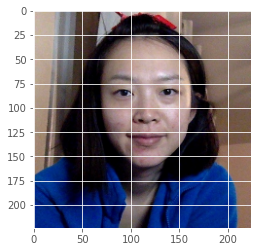

In [0]:

image = cv2.imread('/content/test.jpg')[...,::-1]
face_locations = face_recognition.face_locations(image)

if len(face_locations)==1:
    top, right, bottom, left = face_locations[0]
    # print('top, right, bottom, left:',top, right, bottom, left)
    weight = right-left
    hight = bottom-top

    x_pad = weight//2
    y_pad = hight//2

    left = left-x_pad if (left-x_pad)>0 else 0
    right = right+x_pad if (right+x_pad)<image.shape[1]  else image.shape[1]
    top = top-y_pad if (top-y_pad)>0 else 0
    bottom = bottom+y_pad if (bottom+y_pad)<image.shape[0] else image.shape[0]

    face_cut = image[top:bottom, left:right]

image_test = tf.image.resize(face_cut, [IMG_SIZE, IMG_SIZE])/255
image_test = tf.reshape(image_test, [1, IMG_SIZE, IMG_SIZE, 3])
# model(image_test)
age_class = np.argmax(model(image_test)[0])
print(age_list[age_class])
plt.imshow(image_test[0])


10


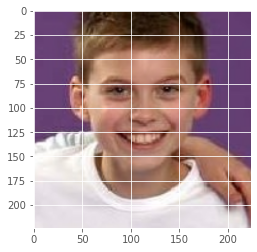

In [0]:
i = 45
age_class = np.argmax(model(img)[0][i])
print(age_list[age_class])
plt.imshow(img[i])


In [0]:
age_list

[0, 10, 18, 25, 30, 35, 40, 50, 60, 120]